# Stock NeurIPS2018 Part 2. Train
This series is a reproduction of *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*.

This is the second part of the NeurIPS2018 series, introducing how to use FinRL to make data into the gym form environment, and train DRL agents on it.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [1]:
## install finrl library
!pip install websockets==15.0.1
!pip install git+https://github.com/andwir/FinRL-Mods.git

  Cloning https://github.com/andwir/FinRL-Mods.git to /tmp/pip-req-build-cr89s_l7
  Running command git clone --filter=blob:none --quiet https://github.com/andwir/FinRL-Mods.git /tmp/pip-req-build-cr89s_l7
  Resolved https://github.com/andwir/FinRL-Mods.git to commit 9f9905ed84c7b8d97a86ecf66ae3c6aa85ab8c61
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-qi3ypqsl/elegantrl_6b92fa5ef9e04c34ae5ca78b55b83361
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-qi3ypqsl/elegantrl_6b92fa5ef9e04c34ae5ca78b55b83361
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 8ea76afc3e7f1564ae9f0e69e70254116d575fe9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 13.5 MB/s eta 0:00:00
 

In [2]:

!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

# Part 2. Build A Market Environment in OpenAI Gym-style

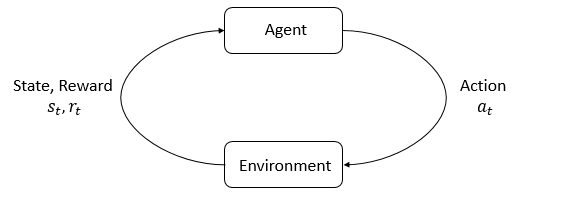

The core element in reinforcement learning are **agent** and **environment**. You can understand RL as the following process:

The agent is active in a world, which is the environment. It observe its current condition as a **state**, and is allowed to do certain **actions**. After the agent execute an action, it will arrive at a new state. At the same time, the environment will have feedback to the agent called **reward**, a numerical signal that tells how good or bad the new state is. As the figure above, agent and environment will keep doing this interaction.

The goal of agent is to get as much cumulative reward as possible. Reinforcement learning is the method that agent learns to improve its behavior and achieve that goal.

To achieve this in Python, we follow the OpenAI gym style to build the stock data into environment.

state-action-reward are specified as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes the price data and technical indicators based on the past data. It will learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 constituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.

## Read data

We first read the .csv file of our training data into dataframe.

In [5]:
train = pd.read_csv('train_data.csv')
# If you are not using the data generated from part 1 of this tutorial, make sure
# it has the columns and index in the form that could be make into the environment.
# Then you can comment and skip the following two lines.
train = train.set_index(train.columns[0])
train.index.names = ['']

## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [6]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}, len(INDICATORS): {len(INDICATORS)}")

Stock Dimension: 29, State Space: 291, len(INDICATORS): 8


In [7]:
buy_cost_list = sell_cost_list = [0.01] * stock_dimension
num_stock_shares = [0] * stock_dimension
print(f"[0]: {[0]} num_stock_shares:{num_stock_shares}")

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

[0]: [0] num_stock_shares:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Environment for training

In [8]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 3: Train DRL Agents
* Here, the DRL algorithms are from **[Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/)**. It's a library that implemented popular DRL algorithms using pytorch, succeeding to its old version: Stable Baselines.
* Users are also encouraged to try **[ElegantRL](https://github.com/AI4Finance-Foundation/ElegantRL)** and **[Ray RLlib](https://github.com/ray-project/ray)**.

In [9]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

## Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [10]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [11]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 86        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -0.0242   |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -77.7     |
|    reward             | 0.1567285 |
|    std                | 1         |
|    value_loss         | 5.49      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 87         |
|    iterations         | 200        |
|    time_elapsed       | 11         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

In [12]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [13]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [14]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 5031268.44
total_reward: 4031268.44
total_cost: 48894.08
total_trades: 50315
Sharpe: 0.931
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 66        |
|    time_elapsed    | 172       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -624      |
|    critic_loss     | 1e+03     |
|    learning_rate   | 0.001     |
|    n_updates       | 11471     |
|    reward          | 3.9063754 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 66        |
|    time_elapsed    | 346       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | -394      |
|    critic_loss     | 13.8      |
|    learning_rate   | 0.001     |
|    n_updates       | 23043     |

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [15]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [16]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [17]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

-------------------------------------
| time/              |              |
|    fps             | 97           |
|    iterations      | 1            |
|    time_elapsed    | 20           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.060280338 |
-------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 99         |
|    iterations           | 2          |
|    time_elapsed         | 41         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.0148851  |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | -0.0996    |
|    learning_rate        | 0.00025    |
|    loss                 | 1.11       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0345    |
| 

In [20]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [18]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3


In [19]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

day: 2892, episode: 110
begin_total_asset: 1000000.00
end_total_asset: 5616463.37
total_reward: 4616463.37
total_cost: 11680.19
total_trades: 26154
Sharpe: 0.908
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 69        |
|    time_elapsed    | 165       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 108       |
|    critic_loss     | 181       |
|    learning_rate   | 0.001     |
|    n_updates       | 11471     |
|    reward          | 5.7246976 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 69        |
|    time_elapsed    | 332       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 73.8      |
|    critic_loss     | 41.4      |
|    learning_rate   | 0.001     |
|    n_updates       | 23043     

In [21]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

In [22]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [ ]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 49       |
|    time_elapsed    | 232      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 679      |
|    critic_loss     | 101      |
|    ent_coef        | 0.159    |
|    ent_coef_loss   | -85.1    |
|    learning_rate   | 0.0001   |
|    n_updates       | 11471    |
|    reward          | 3.089759 |
---------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 6474524.88
total_reward: 5474524.88
total_cost: 1107649.16
total_trades: 66262
Sharpe: 0.894


In [ ]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## Save the trained agent
Trained agents should have already been saved in the "trained_models" drectory after you run the code blocks above.

For Colab users, the zip files should be at "./trained_models" or "/content/trained_models".

For users running on your local environment, the zip files should be at "./trained_models".